In [5]:
import matplotlib.pyplot as plt


In [6]:
!pip install torch torchvision transformers h5py Pillow gdown tqdm

In [7]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 17.6 MB/s eta 0:00:00


In [8]:
import torch

def check_gpu():
    if torch.cuda.is_available():
        print(f"GPU available: {torch.cuda.get_device_name(0)}")
        print(f"Number of GPUs: {torch.cuda.device_count()}")
        return torch.device('cuda')
    else:
        print("No GPU available, using CPU")
        return torch.device('cpu')

device = check_gpu()

GPU available: Tesla T4
Number of GPUs: 1


In [9]:
import torch
import torch.nn as nn
from transformers import ViTModel
import torch.nn.functional as F

class DepthEstimationModel(nn.Module):
    def __init__(self, pretrained_vit_name="google/vit-base-patch16-224"):
        super(DepthEstimationModel, self).__init__()

        # Load pre-trained ViT
        self.vit = ViTModel.from_pretrained(pretrained_vit_name)
        hidden_size = self.vit.config.hidden_size

        print(f"hidden_size = {hidden_size}")

        # Freeze ViT parameters
        for param in self.vit.parameters():
            param.requires_grad = False

        # Unfreeze last transformer block
        for param in self.vit.encoder.layer[-1].parameters():
            param.requires_grad = True

        # Decoder layers
        self.decoder = nn.Sequential(
            nn.Linear(hidden_size, 256),
            nn.LayerNorm(256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, 128),
            nn.LayerNorm(128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )


        self.upsample = nn.Sequential(
            # First, reduce channels from 768 to 512
            nn.Conv2d(hidden_size, 512, kernel_size=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),

            # Upsampling blocks
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            # Final convolution to get single-channel depth
            nn.Conv2d(32, 1, kernel_size=3, padding=1),
            nn.ReLU()
        )

    def forward(self, x):
        # Get ViT features
        vit_output = self.vit(x)
        hidden_states = vit_output.last_hidden_state

        # use all tokens, not just CLS
        features = hidden_states[:, 1:].reshape(x.shape[0], 14, 14, -1).permute(0, 3, 1, 2)

        # Upsample directly from feature map
        depth = self.upsample(features)
        return depth


# Training function
def train_depth_model(model, train_loader, optimizer, criterion, device, num_epochs=10):
    model = model.to(device)  # Ensure model is on GPU
    scaler = torch.cuda.amp.GradScaler()  # For mixed precision training

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0

        for batch_idx, (images, depth_gt) in enumerate(tqdm(train_loader)):
            images = images.to(device, non_blocking=True)
            depth_gt = depth_gt.to(device, non_blocking=True)

            optimizer.zero_grad()

            # Use mixed precision training
            with torch.cuda.amp.autocast():
                depth_pred = model(images)
                loss = criterion(depth_pred, depth_gt)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            total_loss += loss.item()

            if batch_idx % 10 == 0:
                print(f'Epoch {epoch+1}/{num_epochs}, Batch {batch_idx}, Loss: {loss.item():.4f}')
                # Monitor GPU memory
                if torch.cuda.is_available():
                    print(f'GPU Memory: {torch.cuda.memory_allocated() / 1e9:.2f}GB')

        avg_loss = total_loss / len(train_loader)
        print(f'Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.4f}')


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [10]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import h5py
import numpy as np
import os
from PIL import Image
import requests
import gdown
from tqdm import tqdm

class NYUDepthV2Dataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform

        print("Loading NYU Depth V2 dataset...")
        self.data = h5py.File(os.path.join(data_dir, 'nyu_depth_v2_labeled.mat'), 'r')
        self.images = np.array(self.data['images'])  # Convert to numpy array immediately
        self.depths = np.array(self.data['depths'])  # Convert to numpy array immediately

    def __len__(self):
        return self.images.shape[0]

    def __getitem__(self, idx):
        # Get image and depth
        image = self.images[idx].transpose(2, 1, 0)  # HWC format
        depth = self.depths[idx]

        # Normalize depth to [0, 1]
        depth = (depth - depth.min()) / (depth.max() - depth.min())

        # Convert image to PIL Image (ensure it's uint8)
        image = Image.fromarray(np.uint8(image))

        # Apply transforms to image
        if self.transform:
            image = self.transform(image)

        # Process depth
        depth = torch.from_numpy(depth).float()
        depth = F.interpolate(depth.unsqueeze(0).unsqueeze(0),
                         size=(224, 224),
                         mode='bilinear',
                         align_corners=True).squeeze(0)

        return image, depth

def verify_data_alignment(dataset, num_samples=3):
    fig, axes = plt.subplots(num_samples, 2, figsize=(10, 5*num_samples))
    for i in range(num_samples):
        image, depth = dataset[i]

        # Denormalize image for display
        img_display = image.permute(1, 2, 0).numpy()
        img_display = img_display * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img_display = np.clip(img_display, 0, 1)

        # Display image
        axes[i, 0].imshow(img_display)
        axes[i, 0].set_title(f'Image {i}')
        axes[i, 0].axis('off')

        # Display depth
        axes[i, 1].imshow(depth[0], cmap='plasma')
        axes[i, 1].set_title(f'Depth {i}')
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()


def download_nyu_dataset(data_dir):
    """Download NYU Depth V2 labeled dataset"""
    os.makedirs(data_dir, exist_ok=True)

    # Alternative URL for the labeled dataset
    url = "http://horatio.cs.nyu.edu/mit/silberman/nyu_depth_v2/nyu_depth_v2_labeled.mat"
    output_path = os.path.join(data_dir, 'nyu_depth_v2_labeled.mat')

    if not os.path.exists(output_path):
        print(f"Downloading NYU Depth V2 dataset to {output_path}")
        try:
            import wget
            wget.download(url, output_path)
        except ImportError:
            print("Installing wget...")
            !pip install wget
            import wget
            wget.download(url, output_path)
    else:
        print("Dataset already exists.")


In [11]:
!pip install pytorch_msssim

In [12]:
from pytorch_msssim import SSIM

class DepthLoss(nn.Module):
    def __init__(self):
        super(DepthLoss, self).__init__()
        self.ssim = SSIM(data_range=1.0, size_average=True, channel=1)

    def forward(self, pred, target):
        # L1 loss
        l1_loss = F.l1_loss(pred, target)

        # Gradient loss
        grad_pred_x = torch.abs(pred[:, :, :, :-1] - pred[:, :, :, 1:])
        grad_pred_y = torch.abs(pred[:, :, :-1, :] - pred[:, :, 1:, :])
        grad_target_x = torch.abs(target[:, :, :, :-1] - target[:, :, :, 1:])
        grad_target_y = torch.abs(target[:, :, :-1, :] - target[:, :, 1:, :])

        grad_loss = F.l1_loss(grad_pred_x, grad_target_x) + F.l1_loss(grad_pred_y, grad_target_y)

        # SSIM loss for structure preservation
        ssim_loss = 1 - self.ssim(pred, target)

        return 0.8 * l1_loss + 0.1 * grad_loss + 0.1 * ssim_loss

In [13]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set data directory
data_dir = 'nyu_depth_v2_data'

# Download dataset
download_nyu_dataset(data_dir)

# Define transforms

# Adding data aug and lighting changes
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    # transforms.RandomHorizontalFlip(),  # Data augmentation
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Lighting changes
    transforms.ToTensor(),
    # Using ImageNet stats since ViT was pretrained on it
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

# Create dataset and dataloader
dataset = NYUDepthV2Dataset(data_dir, transform=transform)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True,
    num_workers=2, # changed from 4
    pin_memory=True,  # This helps speed up data transfer to GPU
    persistent_workers=True  # Keeps worker processes alive between batches
)

val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=4)

# Initialize model, optimizer, and loss function
model = DepthEstimationModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
# criterion = nn.L1Loss()
criterion = DepthLoss() # custom

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3, verbose=True
)

# Training loop
num_epochs = 4
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for batch_idx, (images, depths) in enumerate(tqdm(train_loader)):
        images = images.to(device)
        depths = depths.to(device)

        optimizer.zero_grad()
        depth_pred = model(images)

        loss = criterion(depth_pred, depths)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        if batch_idx % 10 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Batch {batch_idx}, Loss: {loss.item():.4f}')

    avg_loss = total_loss / len(train_loader)
    print(f'Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.4f}')

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, depths in val_loader:
            images = images.to(device)
            depths = depths.to(device)
            depth_pred = model(images)
            val_loss += criterion(depth_pred, depths).item()

    avg_val_loss = val_loss / len(val_loader)
    print(f'Validation Loss: {avg_val_loss:.4f}')

    # Update learning rate based on validation loss
    scheduler.step(avg_val_loss)

    # Save model checkpoint
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': avg_loss,
    }, f'depth_model_checkpoint_epoch_{epoch}.pth')

Using device: cuda
Installing wget...
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=2aaeedb573751638e4209b607866361421858307d796de9ecb29c9f34ffeeb16
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget
Loading NYU Depth V2 dataset...


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


hidden_size = 768


  1%|          | 1/145 [00:02<06:38,  2.77s/it]

Epoch 1/4, Batch 0, Loss: 0.4415


  8%|▊         | 12/145 [00:04<00:23,  5.75it/s]

Epoch 1/4, Batch 10, Loss: 0.3580


 15%|█▌        | 22/145 [00:06<00:22,  5.51it/s]

Epoch 1/4, Batch 20, Loss: 0.3533


 22%|██▏       | 32/145 [00:08<00:23,  4.84it/s]

Epoch 1/4, Batch 30, Loss: 0.4171


 29%|██▉       | 42/145 [00:10<00:15,  6.75it/s]

Epoch 1/4, Batch 40, Loss: 0.3169


 36%|███▌      | 52/145 [00:11<00:13,  7.10it/s]

Epoch 1/4, Batch 50, Loss: 0.3355


 43%|████▎     | 62/145 [00:13<00:11,  7.04it/s]

Epoch 1/4, Batch 60, Loss: 0.3512


 50%|████▉     | 72/145 [00:14<00:10,  7.09it/s]

Epoch 1/4, Batch 70, Loss: 0.3498


 57%|█████▋    | 82/145 [00:15<00:08,  7.11it/s]

Epoch 1/4, Batch 80, Loss: 0.3261


 63%|██████▎   | 92/145 [00:17<00:07,  7.02it/s]

Epoch 1/4, Batch 90, Loss: 0.3313


 70%|███████   | 102/145 [00:18<00:06,  7.02it/s]

Epoch 1/4, Batch 100, Loss: 0.3250


 77%|███████▋  | 112/145 [00:20<00:04,  6.62it/s]

Epoch 1/4, Batch 110, Loss: 0.3217


 84%|████████▍ | 122/145 [00:21<00:04,  5.75it/s]

Epoch 1/4, Batch 120, Loss: 0.3280


 90%|█████████ | 131/145 [00:24<00:03,  3.52it/s]

Epoch 1/4, Batch 130, Loss: 0.3237


 98%|█████████▊| 142/145 [00:26<00:00,  5.25it/s]

Epoch 1/4, Batch 140, Loss: 0.2940


100%|██████████| 145/145 [00:27<00:00,  5.32it/s]

Epoch 1/4, Average Loss: 0.3406


Validation Loss: 0.3202


  1%|▏         | 2/145 [00:00<00:35,  4.02it/s]

Epoch 2/4, Batch 0, Loss: 0.3328


  8%|▊         | 12/145 [00:01<00:19,  6.90it/s]

Epoch 2/4, Batch 10, Loss: 0.3338


 15%|█▌        | 22/145 [00:03<00:17,  7.02it/s]

Epoch 2/4, Batch 20, Loss: 0.2981


 22%|██▏       | 32/145 [00:04<00:16,  6.83it/s]

Epoch 2/4, Batch 30, Loss: 0.3313


 29%|██▉       | 42/145 [00:06<00:14,  6.94it/s]

Epoch 2/4, Batch 40, Loss: 0.2946


 36%|███▌      | 52/145 [00:07<00:13,  6.90it/s]

Epoch 2/4, Batch 50, Loss: 0.2796


 43%|████▎     | 62/145 [00:09<00:11,  7.01it/s]

Epoch 2/4, Batch 60, Loss: 0.3263


 49%|████▉     | 71/145 [00:10<00:12,  5.96it/s]

Epoch 2/4, Batch 70, Loss: 0.2907


 56%|█████▌    | 81/145 [00:12<00:11,  5.50it/s]

Epoch 2/4, Batch 80, Loss: 0.2878


 63%|██████▎   | 91/145 [00:14<00:11,  4.76it/s]

Epoch 2/4, Batch 90, Loss: 0.3036


 70%|███████   | 102/145 [00:16<00:06,  6.76it/s]

Epoch 2/4, Batch 100, Loss: 0.2877


 77%|███████▋  | 112/145 [00:17<00:04,  7.03it/s]

Epoch 2/4, Batch 110, Loss: 0.2982


 84%|████████▍ | 122/145 [00:19<00:03,  6.90it/s]

Epoch 2/4, Batch 120, Loss: 0.2849


 91%|█████████ | 132/145 [00:20<00:01,  6.94it/s]

Epoch 2/4, Batch 130, Loss: 0.2949


 98%|█████████▊| 142/145 [00:22<00:00,  7.07it/s]

Epoch 2/4, Batch 140, Loss: 0.2809


100%|██████████| 145/145 [00:22<00:00,  6.42it/s]

Epoch 2/4, Average Loss: 0.3041


Validation Loss: 0.3047


  1%|▏         | 2/145 [00:00<00:38,  3.76it/s]

Epoch 3/4, Batch 0, Loss: 0.2874


  8%|▊         | 12/145 [00:02<00:19,  6.95it/s]

Epoch 3/4, Batch 10, Loss: 0.2838


 15%|█▌        | 22/145 [00:03<00:17,  6.84it/s]

Epoch 3/4, Batch 20, Loss: 0.2728


 22%|██▏       | 32/145 [00:04<00:16,  6.99it/s]

Epoch 3/4, Batch 30, Loss: 0.2805


 29%|██▉       | 42/145 [00:06<00:14,  6.99it/s]

Epoch 3/4, Batch 40, Loss: 0.2822


 36%|███▌      | 52/145 [00:07<00:13,  7.00it/s]

Epoch 3/4, Batch 50, Loss: 0.2635


 43%|████▎     | 62/145 [00:09<00:12,  6.91it/s]

Epoch 3/4, Batch 60, Loss: 0.2834


 50%|████▉     | 72/145 [00:10<00:11,  6.50it/s]

Epoch 3/4, Batch 70, Loss: 0.2956


 57%|█████▋    | 82/145 [00:12<00:10,  5.76it/s]

Epoch 3/4, Batch 80, Loss: 0.3205


 63%|██████▎   | 91/145 [00:14<00:10,  5.01it/s]

Epoch 3/4, Batch 90, Loss: 0.2683


 70%|███████   | 102/145 [00:16<00:06,  6.29it/s]

Epoch 3/4, Batch 100, Loss: 0.2915


 77%|███████▋  | 112/145 [00:17<00:04,  6.85it/s]

Epoch 3/4, Batch 110, Loss: 0.2989


 84%|████████▍ | 122/145 [00:19<00:03,  6.90it/s]

Epoch 3/4, Batch 120, Loss: 0.2854


 91%|█████████ | 132/145 [00:20<00:01,  6.85it/s]

Epoch 3/4, Batch 130, Loss: 0.2747


 98%|█████████▊| 142/145 [00:22<00:00,  6.90it/s]

Epoch 3/4, Batch 140, Loss: 0.2940


100%|██████████| 145/145 [00:22<00:00,  6.45it/s]

Epoch 3/4, Average Loss: 0.2877


Validation Loss: 0.2998


  1%|▏         | 2/145 [00:00<00:34,  4.20it/s]

Epoch 4/4, Batch 0, Loss: 0.2670


  8%|▊         | 12/145 [00:01<00:19,  6.77it/s]

Epoch 4/4, Batch 10, Loss: 0.2711


 15%|█▌        | 22/145 [00:03<00:17,  6.99it/s]

Epoch 4/4, Batch 20, Loss: 0.2827


 22%|██▏       | 32/145 [00:04<00:16,  6.75it/s]

Epoch 4/4, Batch 30, Loss: 0.2795


 29%|██▉       | 42/145 [00:06<00:14,  6.87it/s]

Epoch 4/4, Batch 40, Loss: 0.2635


 36%|███▌      | 52/145 [00:07<00:13,  7.01it/s]

Epoch 4/4, Batch 50, Loss: 0.2765


 43%|████▎     | 62/145 [00:09<00:11,  6.92it/s]

Epoch 4/4, Batch 60, Loss: 0.2747


 50%|████▉     | 72/145 [00:10<00:11,  6.47it/s]

Epoch 4/4, Batch 70, Loss: 0.2854


 56%|█████▌    | 81/145 [00:12<00:17,  3.58it/s]

Epoch 4/4, Batch 80, Loss: 0.2683


 63%|██████▎   | 92/145 [00:16<00:13,  3.93it/s]

Epoch 4/4, Batch 90, Loss: 0.2869


 70%|███████   | 102/145 [00:17<00:06,  6.75it/s]

Epoch 4/4, Batch 100, Loss: 0.2781


 77%|███████▋  | 112/145 [00:19<00:04,  6.85it/s]

Epoch 4/4, Batch 110, Loss: 0.2601


 84%|████████▍ | 122/145 [00:20<00:03,  6.74it/s]

Epoch 4/4, Batch 120, Loss: 0.2833


 91%|█████████ | 132/145 [00:22<00:01,  6.87it/s]

Epoch 4/4, Batch 130, Loss: 0.2643


 98%|█████████▊| 142/145 [00:23<00:00,  6.85it/s]

Epoch 4/4, Batch 140, Loss: 0.2721


100%|██████████| 145/145 [00:24<00:00,  6.03it/s]

Epoch 4/4, Average Loss: 0.2803


Validation Loss: 0.2979


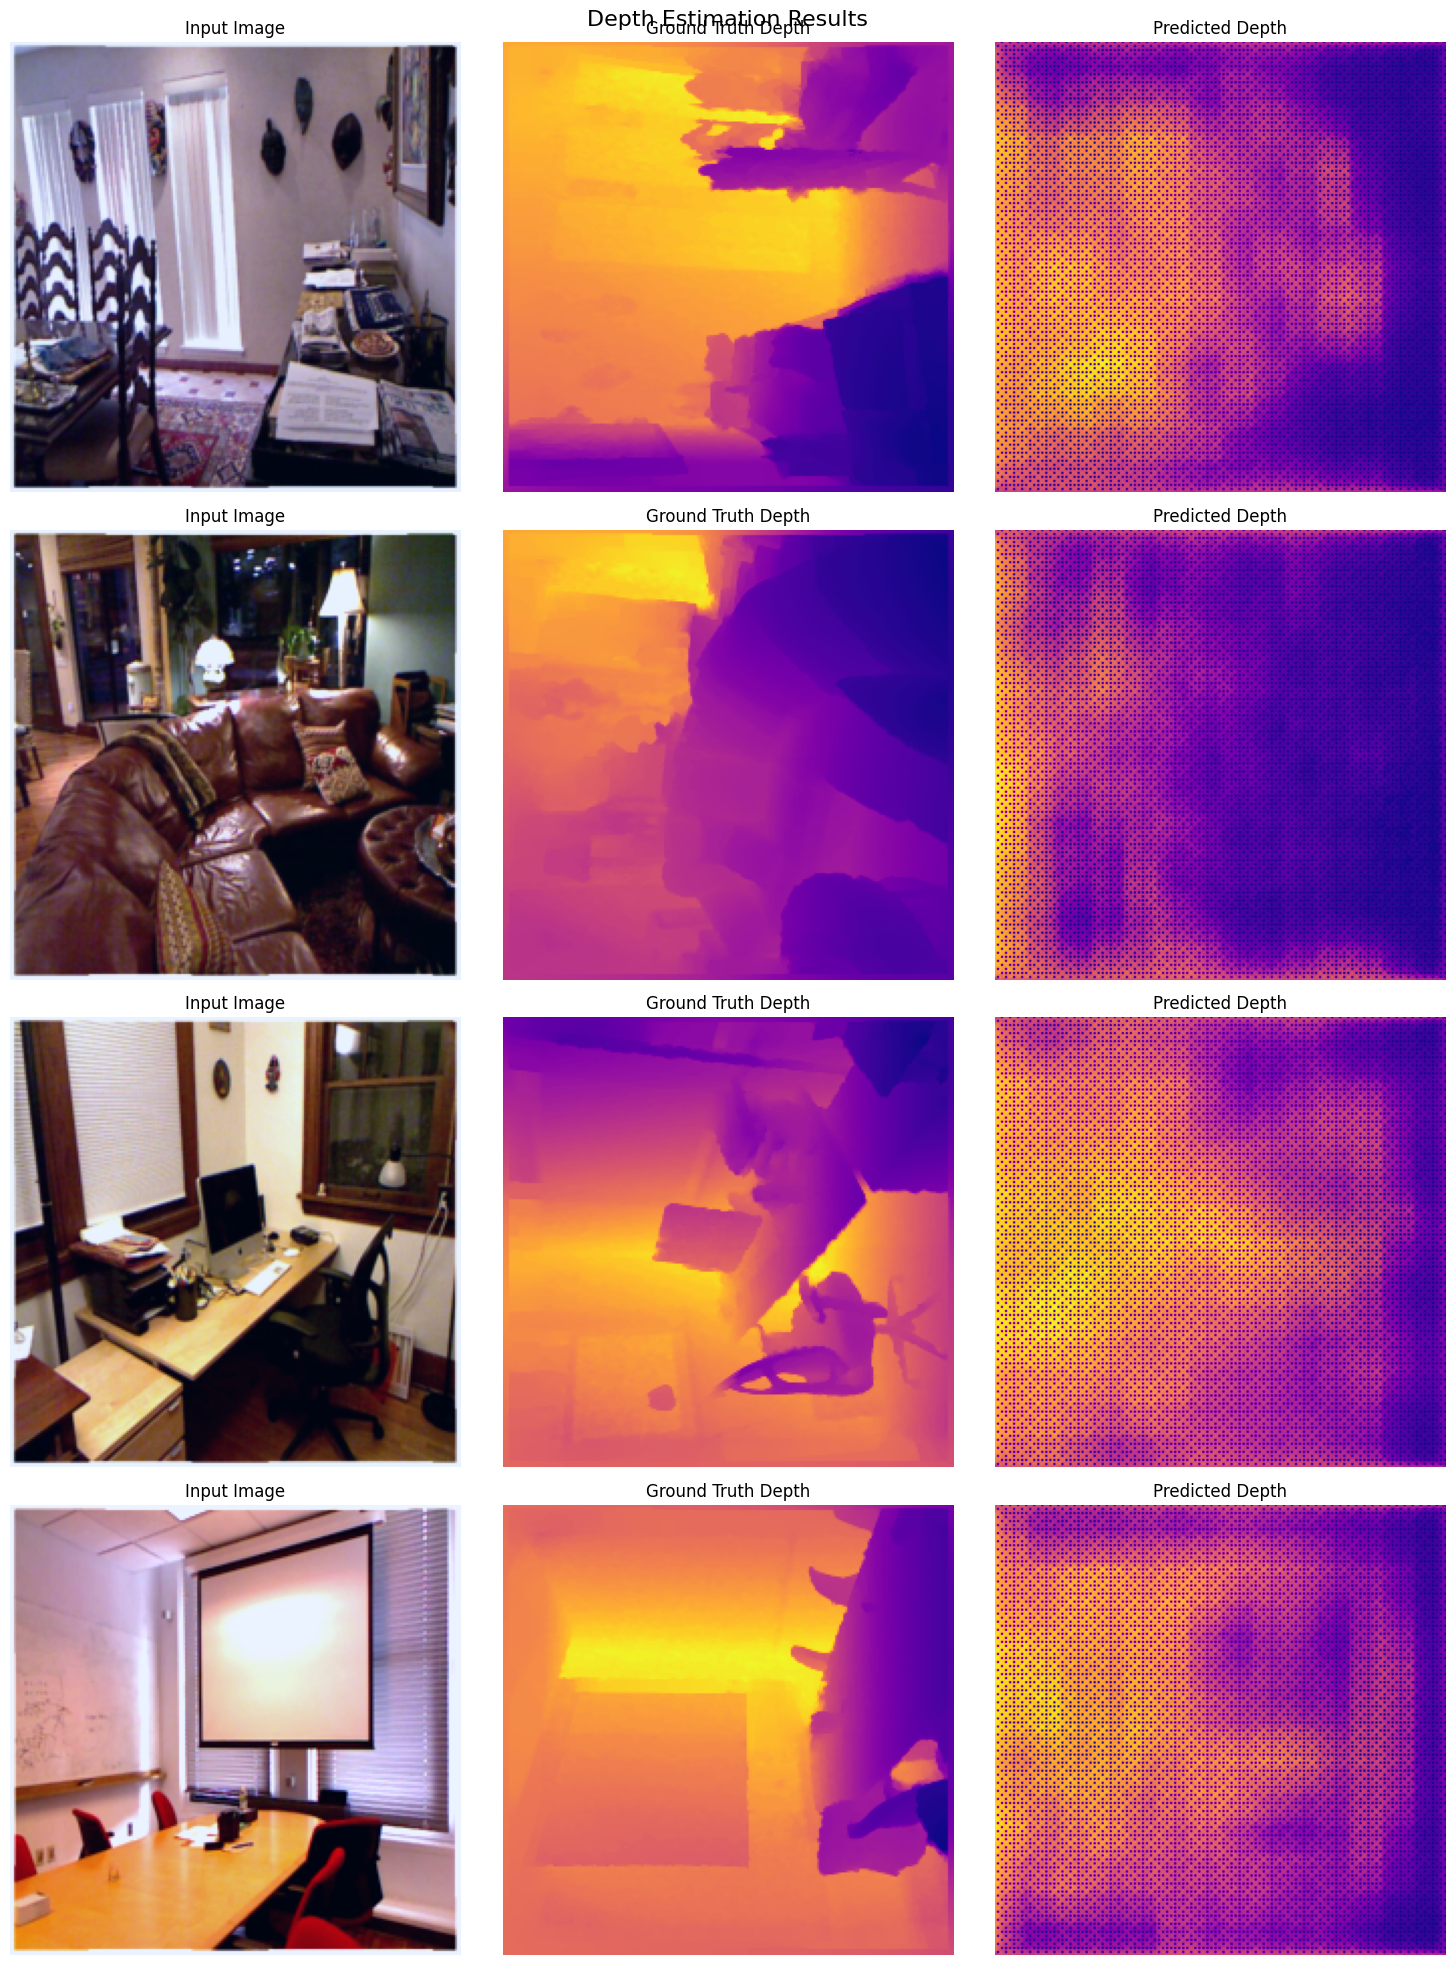

Evaluation Metrics:
Average L1 Loss: 0.2304
Average RMSE: 0.3018


In [14]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

def visualize_predictions(model, val_loader, device, num_samples=4):
    """
    Visualize model predictions alongside ground truth depth maps
    """
    model.eval()

    # Get a batch of validation data
    images, depths = next(iter(val_loader))
    images = images[:num_samples].to(device)
    depths = depths[:num_samples]

    with torch.no_grad():
        predictions = model(images)

    # Move tensors to CPU and convert to numpy arrays
    images = images.cpu()
    depths = depths.cpu()
    predictions = predictions.cpu()

    # Create figure
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5*num_samples))
    plt.suptitle('Depth Estimation Results', fontsize=16)

    for i in range(num_samples):
        # Original image
        img = images[i].permute(1, 2, 0).numpy()
        img = (img - img.min()) / (img.max() - img.min())  # Normalize for visualization
        axes[i, 0].imshow(img)
        axes[i, 0].set_title('Input Image')
        axes[i, 0].axis('off')

        # Ground truth depth
        axes[i, 1].imshow(depths[i, 0], cmap='plasma')
        axes[i, 1].set_title('Ground Truth Depth')
        axes[i, 1].axis('off')

        # Predicted depth
        axes[i, 2].imshow(predictions[i, 0], cmap='plasma')
        axes[i, 2].set_title('Predicted Depth')
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

def compute_metrics(model, val_loader, device):
    """
    Compute quantitative metrics for model evaluation
    """
    model.eval()
    total_l1_loss = 0
    total_rmse = 0
    num_samples = 0

    with torch.no_grad():
        for images, depths in val_loader:
            images = images.to(device)
            depths = depths.to(device)
            predictions = model(images)

            # Compute metrics
            l1_loss = F.l1_loss(predictions, depths).item()
            rmse = torch.sqrt(F.mse_loss(predictions, depths)).item()

            # Accumulate metrics
            batch_size = images.size(0)
            total_l1_loss += l1_loss * batch_size
            total_rmse += rmse * batch_size
            num_samples += batch_size

    # Compute average metrics
    avg_l1_loss = total_l1_loss / num_samples
    avg_rmse = total_rmse / num_samples

    print(f"Evaluation Metrics:")
    print(f"Average L1 Loss: {avg_l1_loss:.4f}")
    print(f"Average RMSE: {avg_rmse:.4f}")

    return avg_l1_loss, avg_rmse

# After training completes, you can use these functions:
visualize_predictions(model, val_loader, device)
compute_metrics(model, val_loader, device)

# If you want to test on a single image:
def predict_single_image(model, image_path, device):
    """
    Make prediction for a single image
    """
    # Load and preprocess image
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])
    ])

    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)

    # Make prediction
    model.eval()
    with torch.no_grad():
        depth = model(image_tensor)

    # Visualize
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title('Input Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(depth[0, 0].cpu(), cmap='plasma')
    plt.title('Predicted Depth')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# To use on a single image:
# predict_single_image(model, 'path_to_your_image.jpg', device)

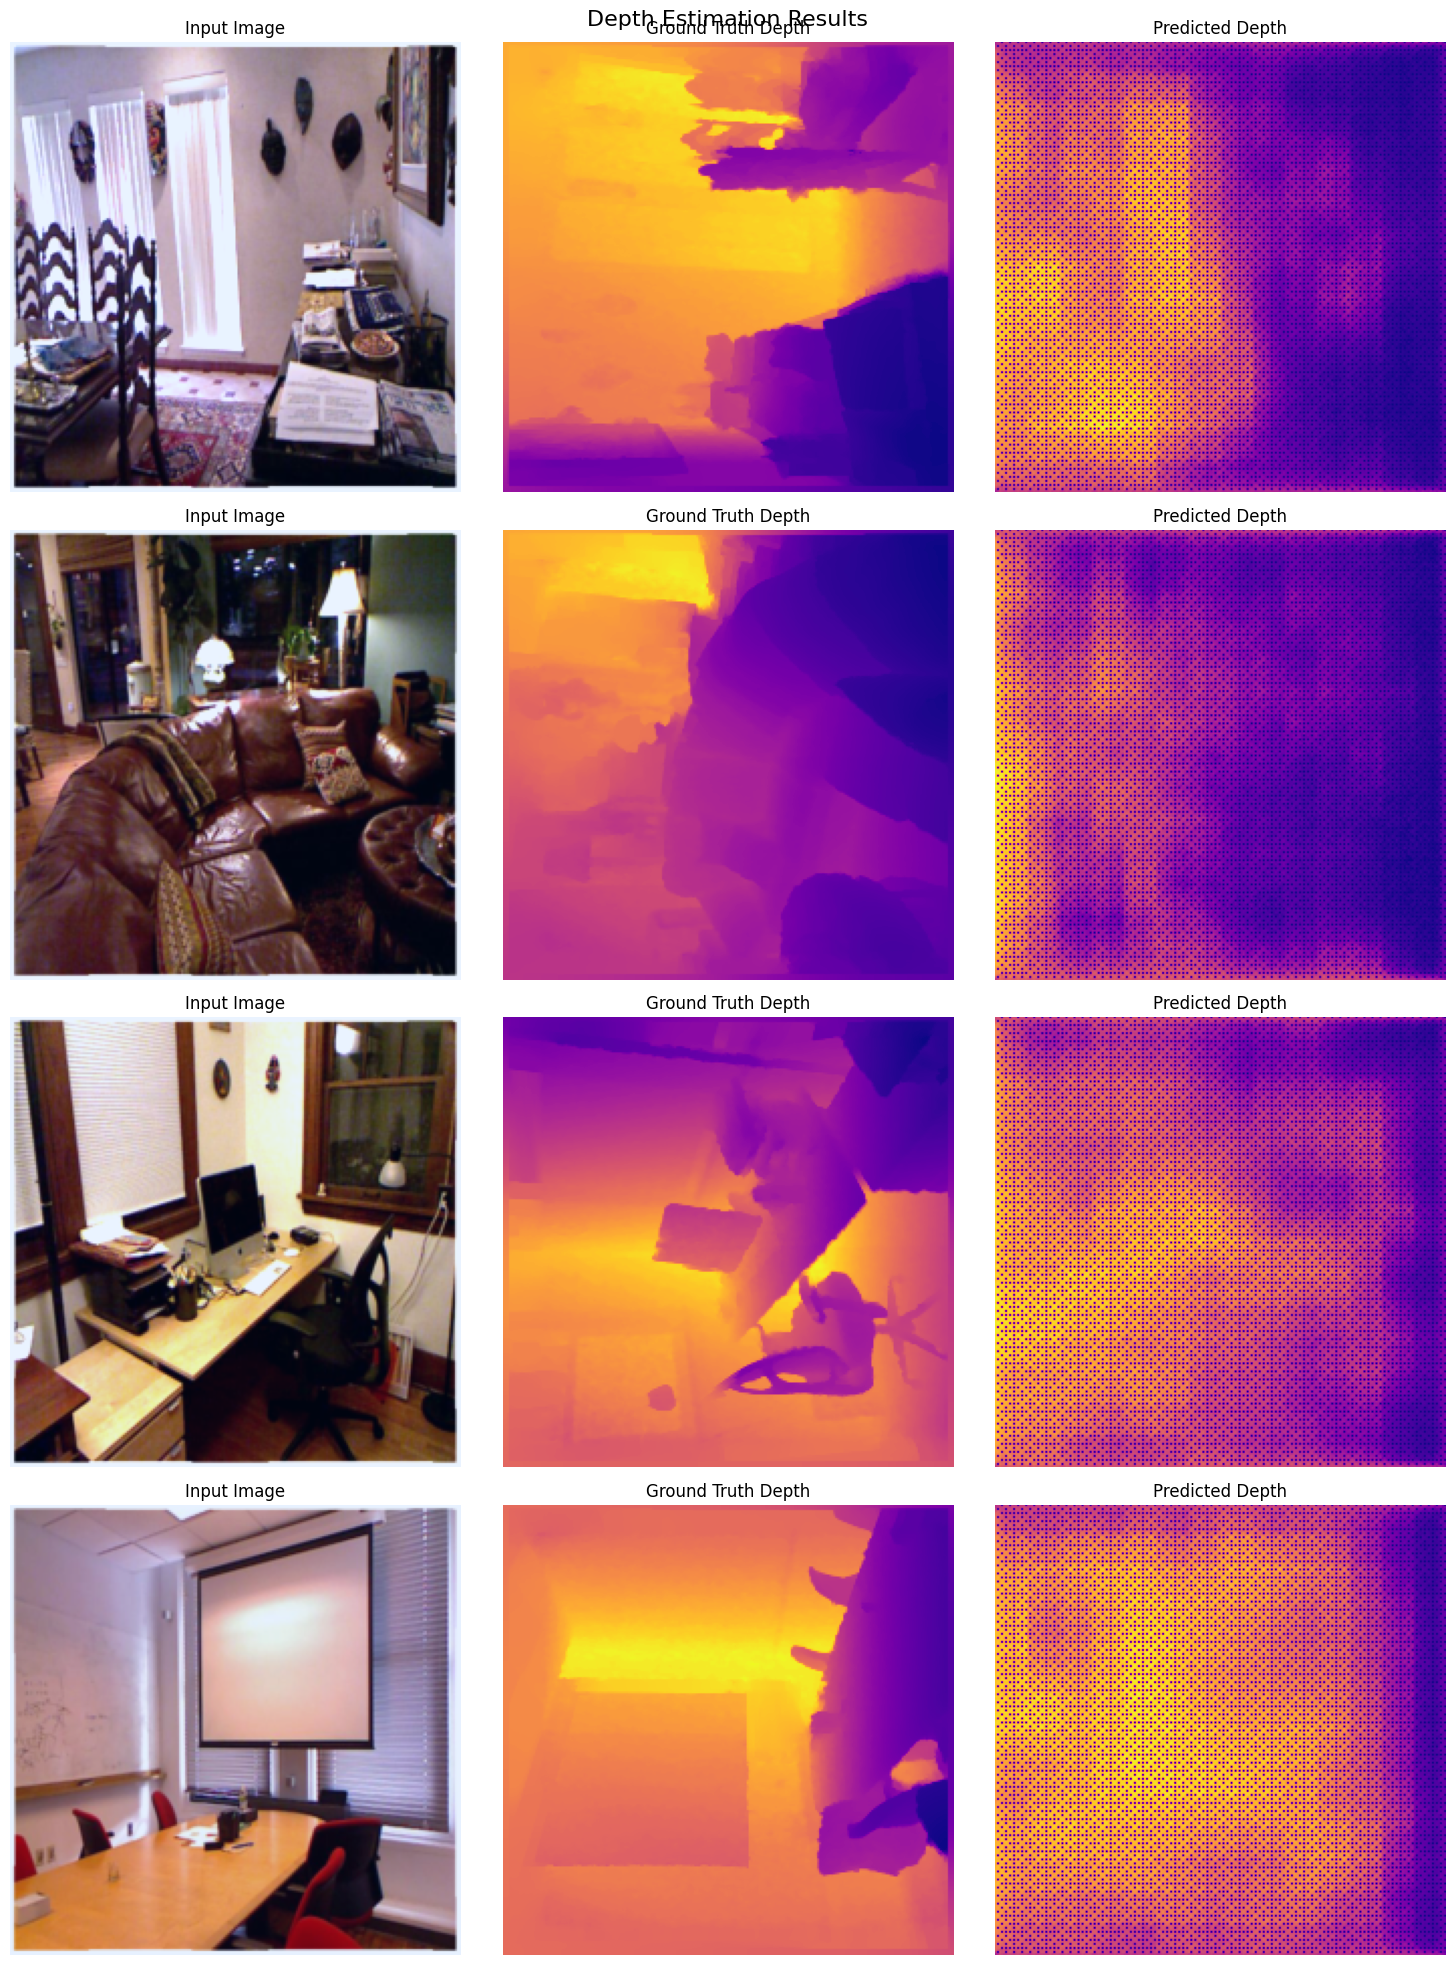

In [19]:
visualize_predictions(model, val_loader, device)

In [ ]:
compute_metrics(model, val_loader, device)

Evaluation Metrics:
Average L1 Loss: 0.2231
Average RMSE: 0.2898


(0.22306401287687236, 0.289849038473491)

### Evaluation


In [1]:
!pip install timm==0.6.7 plotly datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.0/510.0 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
  Attempting uninstall: timm
    Found existing installation: timm 1.0.12
    Uninstalling timm-1.0.12:
      Successfully uninstalled timm-1.0.12
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==

In [17]:
# Import necessary libraries
from datasets import load_dataset
from PIL import Image
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math
import torch

torch.hub.help("intel-isl/MiDaS", "DPT_BEiT_L_384", force_reload=True)  # Triggers fresh download of MiDaS repo


repo = "isl-org/ZoeDepth"
# Zoe_N
model_zoe_n = torch.hub.load(repo, "ZoeD_N", pretrained=True)


DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
zoe = model_zoe_n.to(DEVICE)


# Load the dataset
ds = load_dataset("sayakpaul/nyu_depth_v2", streaming=True, split="train", trust_remote_code=True)
def normalize_depth(depth):
    """Normalize a depth map to the range [0, 1]."""
    min_depth = np.min(depth)
    max_depth = np.max(depth)
    if max_depth - min_depth == 0:  # Avoid division by zero
        return np.zeros_like(depth)
    return (depth - min_depth) / (max_depth - min_depth)


# Define utility functions
def compute_metrics(true_depth, predicted_depth):
    """
    Compute evaluation metrics: MAE and RMSE.

    Args:
    - true_depth (numpy.ndarray): Ground truth depth map.
    - predicted_depth (numpy.ndarray): Predicted depth map.

    Returns:
    - dict: Dictionary containing MAE and RMSE values.
    """
    mae = mean_absolute_error(true_depth, predicted_depth)
    rmse = math.sqrt(mean_squared_error(true_depth, predicted_depth))
    return {"MAE": mae, "RMSE": rmse}

def process_depth(depth_pil):
    """
    Convert a PIL depth image to a numpy array and normalize.

    Args:
    - depth_pil (PIL.Image.Image): Depth image as a PIL Image.

    Returns:
    - numpy.ndarray: Normalized depth array.
    """
    depth_array = np.array(depth_pil).astype(np.float32)
    return depth_array / 65535.0  # Normalize 16-bit depth

# Define the evaluation function
def evaluate_model(zoe, dataset, max_samples=100):
    """
    Evaluate a ZoeDepth model on the NYU Depth V2 dataset.

    Args:
    - zoe: ZoeDepth model instance.
    - dataset: Streaming dataset (e.g., NYU Depth V2).
    - max_samples: Maximum number of samples to evaluate.
    - preprocess_fn: Optional preprocessing function for input images.

    Returns:
    - list of dict: Metrics for each sample.
    """
    metrics = []
    for idx, sample in enumerate(dataset):
        # print(sample)
        if idx >= max_samples:
            break

        # Load and preprocess image
        image = sample["image"]
        if isinstance(image, Image.Image):  # Check if already a PIL image
            pass
        else:
            image = Image.open(image).convert("RGB")  # Convert to RGB if necessary

        # Load ground truth depth
        depth = sample["depth_map"]
        if isinstance(depth, Image.Image):  # Check if already a PIL image
            true_depth = process_depth(depth)
        else:
            true_depth = process_depth(Image.open(depth))

        # Predict depth using ZoeDepth
        predicted_depth_pil = zoe.infer_pil(image, output_type="pil")
        predicted_depth = process_depth(predicted_depth_pil)

        # normalize depth
        true_depth = normalize_depth(true_depth)
        predicted_depth = normalize_depth(predicted_depth)



        # Compute metrics
        sample_metrics = compute_metrics(true_depth, predicted_depth)
        metrics.append(sample_metrics)

        # Print progress
        print(f"Processed {idx + 1}/{max_samples} samples: MAE = {sample_metrics['MAE']:.4f}, RMSE = {sample_metrics['RMSE']:.4f}")

    # Compute average metrics
    avg_mae = np.mean([m["MAE"] for m in metrics])
    avg_rmse = np.mean([m["RMSE"] for m in metrics])
    print(f"\nAverage Metrics: MAE = {avg_mae:.4f}, RMSE = {avg_rmse:.4f}")

    return metrics


def evaluate_with_processing(zoe, dataset, processing_fn, max_samples=100, preprocess_fn=None):
    """
    Evaluate a ZoeDepth model with additional post-processing on the NYU Depth V2 dataset.

    Args:
    - zoe: ZoeDepth model instance.
    - dataset: Streaming dataset (e.g., NYU Depth V2).
    - processing_fn: Function to apply additional processing to the predicted depth map.
    - max_samples: Maximum number of samples to evaluate.
    - preprocess_fn: Optional preprocessing function for input images.

    Returns:
    - list of dict: Metrics for each sample.
    """

    metrics = []
    for idx, sample in enumerate(dataset):
        if idx >= max_samples:
            break

        # Load and preprocess image
        image = sample.get("image")

        if isinstance(image, Image.Image):  # Check if already a PIL image
            pass
        else:
            image = Image.open(image).convert("RGB")  # Convert to RGB if necessary

        if preprocess_fn:
            image = preprocess_fn(image)

        # resize image and depth to 224x224
        image = image.resize((224, 224), Image.BILINEAR)

        depth = sample["depth_map"]

        if isinstance(depth, Image.Image):  # Check if already a PIL image
            true_depth = process_depth(depth)
        else:
            true_depth = process_depth(Image.open(depth))


        true_depth = true_depth.resize((224, 224), Image.BILINEAR)

        # Normalize ground truth depth
        true_depth = normalize_depth(true_depth)

        # Predict depth using ZoeDepth and apply post-processing
        processed_pred, raw_pred = processing_fn(image)  # Apply processing_fn to include the sharpening technique

        # Normalize predictions
        raw_pred = normalize_depth(raw_pred)
        processed_pred = normalize_depth(processed_pred)

        # Compute metrics
        raw_metrics = compute_metrics(true_depth, raw_pred)
        processed_metrics = compute_metrics(true_depth, processed_pred)

        metrics.append({
            "raw_metrics": raw_metrics,
            "processed_metrics": processed_metrics,
        })

        # Print progress
        print(f"Processed {idx + 1}/{max_samples} samples")
        print(f"Raw: MAE = {raw_metrics['MAE']:.4f}, RMSE = {raw_metrics['RMSE']:.4f}")
        print(f"Processed: MAE = {processed_metrics['MAE']:.4f}, RMSE = {processed_metrics['RMSE']:.4f}")

    # Compute average metrics
    avg_raw_mae = np.mean([m["raw_metrics"]["MAE"] for m in metrics])
    avg_raw_rmse = np.mean([m["raw_metrics"]["RMSE"] for m in metrics])
    avg_processed_mae = np.mean([m["processed_metrics"]["MAE"] for m in metrics])
    avg_processed_rmse = np.mean([m["processed_metrics"]["RMSE"] for m in metrics])

    print("\nAverage Metrics:")
    print(f"Raw Predictions - MAE = {avg_raw_mae:.4f}, RMSE = {avg_raw_rmse:.4f}")
    print(f"Processed Predictions - MAE = {avg_processed_mae:.4f}, RMSE = {avg_processed_rmse:.4f}")

    return metrics


Downloading: "https://github.com/intel-isl/MiDaS/zipball/master" to /root/.cache/torch/hub/master.zip
Using cache found in /root/.cache/torch/hub/isl-org_ZoeDepth_main


img_size [384, 512]


Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


Params passed to Resize transform:
	width:  512
	height:  384
	resize_target:  True
	keep_aspect_ratio:  True
	ensure_multiple_of:  32
	resize_method:  minimal
Using pretrained resource url::https://github.com/isl-org/ZoeDepth/releases/download/v1.0/ZoeD_M12_N.pt
Loaded successfully


In [18]:
# If you want to test on a single image:
def predict_single_image(image, device="cuda"):
    """
    Make prediction for a single image
    """
    # Load and preprocess image
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])
    ])

    # image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)

    # Make prediction
    model.eval()
    with torch.no_grad():
        depth = model(image_tensor)

    return depth

# To use on a single image:
# predict_single_image(model, 'path_to_your_image.jpg', device)

results = evaluate_with_processing(
    zoe=zoe,
    dataset=ds,
    processing_fn=predict_single_image,
    max_samples=50,
)

TypeError: 'tuple' object cannot be interpreted as an integer